# lattice_mc
`lattice_mc` is Python module for running (kinetic) lattice-gas Monte Carlo simulations. Simple lattices can be constructed programmatically (presently square, honeycomb, and cubic lattices). Arbitrary lattices can be generated from files that define the lattice sites and their connectivity. The algorithms used and interaction models are described in [\[1\]](#ref1). Calculated properties include tracer and &ldquo;jump&rdquo; diffusion coefficients; where the latter is proportional to the mobility (and hence the conductivity for charged particles) [\[2\]](#ref2); and tracer (single particle) and collective correlation factors, $f$ and $f_\mathrm{I}$ [\[3\]](#ref3). The simplest interaction model is for &ldquo;non-interacting&rdquo; particles, where the only restriction is volume exclusion (two particles cannot simultaneously occupy a single site) [\[4\]](#ref4). Additional interaction models include nearest-neighbour repulsion and on-site energies for inequivalent sites.
 
## Contents:

- Simulating the Diffusion of a Single Particle on a Square Lattice.
- Improved Averages using multiprocessing.
- Calculating correlation factors as a function of particle number.
- Interacting Particles:
    - Nearest-Neighbour Repulsion.
        - Example - The Effect of Nearest-Neighbour repulsion on a Honeycomb Lattice.
    - On-site Energies.
        - Example - The Effect of Site Inequivalence on a Honeycomb Lattice
- Defining a Lattice from a Sites File
    - Example: Lattice-Gas Monte Carlo Simulation on a Garnet Lattice.
- Running simulations for a set time, instead of a set number of jumps

In [32]:
import lattice_mc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import multiprocessing
import pandas as pd
from math import sqrt, fabs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [33]:
# Global variables controlling simulation parallelisation and convergence.

# NPROCS sets the number of processors available for running parallel simulations
NPROCS = 32

# NSAMPLES sets the number of identical simulations averaged over for each data point
NSAMPLES = 32

# !!! Large NSAMPLES and small NPROCS will make this notebook very slow to run !!!

In [34]:
# define temperature scale
kT = lattice_mc.global_vars.kT # default setting is T=298 K

## Simulating the diffusion of a single particle on a square lattice
The `run_simulation` function sets up a simulation with a 6&times;6 square lattice, using one of the functions from `lattice_mc.init_lattice`). The simulation parameters are:    
lattice spacing, $a=1$.  
1 atom.  
10000 jumps.  
Particles are non-interacting apart from volume exclusion, because we have not explicitly defined additional interactions. 

In [35]:
def run_simulation():
    a, b = 6, 6 # creates 4x4x4=64 sites
    spacing = 1.0
    n_atoms = 1
    n_jumps = 10000
    s = lattice_mc.Simulation()
    s.lattice = lattice_mc.init_lattice.square_lattice( a, b, spacing )
    s.set_number_of_atoms( n_atoms )
    s.set_number_of_jumps( n_jumps )
    s.run()
    return s
    
s = run_simulation()
print( s )
print( s.has_run )

True


Having run a simulation we can access the following information as properties of the Simulation object:

| Property.                     | symbol          | syntax.                                       |
|-------------------------------|-----------------|-----------------------------------------------|
| has the simulation run?       | N/A             | `Simulation.has_run`                          |
| correlation factor            | $f$             | `Simulation.tracer_correlation`               | 
| collective correlation factor | $f_\mathrm{I}$  | `Simulation.collective_correlation`           |
| tracer diffusion coefficient  | $D^*$           | `Simulation.tracer_diffusion_coefficient`     |
| &ldquo;jump&rdquo; diffusion coefficient  | $D_\mathrm{J}$  | `Simulation.collective_diffusion_coefficient` |
| average site occupations      | occ($\alpha$)   | `Simulation.average_site_occupations`         |

In [36]:
s = run_simulation()
print( "f   = {}".format( s.tracer_correlation ) )
print( "f_I = {}".format( s.collective_correlation ) )
print( "D*  = {:.3e}".format( s.tracer_diffusion_coefficient ) )
print( "D_J = {:.3e}".format( s.collective_diffusion_coefficient ) )
# Simulation.average_site_occupations returns a dictionary
for k, v in s.average_site_occupations.items():
    print( "occ({}) = {:f}".format( k, v ) )

f   = 0.5234
f_I = 0.5234
D*  = 3.575e+12
D_J = 3.575e+12
occ(L) = 1.000000


For a single particle (i.e. in the dilute non-interacting limit) the tracer correlation factor and collective correlation factor should both be equal to 1. This is unlikely here because a single short simulation does not give good statistics.

## Improved averages using multiprocessing

Better converged results are achieved with longer simulations, or by running multiple equivalent simulations and taking averages. On a multiprocessor machine, this parallelisation over simulations can be done by wrapping `run_simulation()` in a second function.

In [37]:
def simulation_wrapper(_):
    s = run_simulation()
    return s.tracer_correlation, s.collective_correlation, s.tracer_diffusion_coefficient, s.collective_diffusion_coefficient

In [38]:
def run_simulations( simulation_function, nproc, n_samples ):
    pool = multiprocessing.Pool( processes=nproc )
    calc_pool = ( range( n_samples ) )
    f_sampled = np.array( pool.map( simulation_function, calc_pool ) )
    f = sum( f_sampled ) / n_samples
    return f

In [39]:
data = run_simulations( simulation_wrapper, nproc=NPROCS, n_samples=NSAMPLES )
print( "f   = {}".format( data[0] ) )
print( "f_I = {}".format( data[1] ) )
print( "D*  = {:.3e}".format( data[2] ) )
print( "D_J = {:.3e}".format( data[3] ) )

f   = 0.994325
f_I = 0.994325
D*  = 6.595e+12
D_J = 6.595e+12


## Calculating correlation factors as a function of particle number

This example calculates the single-particle correlation factor, $f$, and collective correlation factor, $f_I$, as a function of particle concentration, for a honeycomb lattice. Here we create a lookup table for the jump probabilities, using `Simulation.setup_lookup_table`, to speed up the simulation.

In [40]:
def honeycomb_lattice_correlation( n_atoms ):
    a, b = 4, 3
    spacing = 1.0
    n_jumps = 10000 
    s = lattice_mc.Simulation()
    s.lattice = lattice_mc.init_lattice.honeycomb_lattice( a, b, spacing )
    s.set_number_of_atoms( n_atoms )
    s.set_number_of_jumps( n_jumps )
    s.setup_lookup_table() # Create a lookup table for jump probabilities to speed up the simulation
    s.run()
    return s.tracer_correlation, s.collective_correlation

In [41]:
# redefine run_simulations so that it now passes n_atoms through to the simulation function
def run_simulations( n_atoms, simulation_function, nproc, n_samples ):
    pool = multiprocessing.Pool( processes=nproc )
    f_data = []
    for n in n_atoms:
        calc_pool = ( n for i in range( n_samples ) )
        f_sampled = np.array( pool.map( simulation_function, calc_pool ) )
        f = sum( f_sampled ) / n_samples
        f_data.append( [ n, *f ] )
    return f_data

In [42]:
n_atoms = np.array( [ 1, 8, 16, 24, 32, 40, 47 ] )
results = run_simulations( n_atoms, honeycomb_lattice_correlation, nproc=NPROCS, n_samples=NSAMPLES )
data = pd.DataFrame( np.row_stack( results ), columns=[ 'n', 'f', 'f_I' ] )
data

,n,f,f_I
0,1.0,0.787378,0.787378
1,8.0,0.811372,1.129291
2,16.0,0.754019,0.811575
3,24.0,0.616556,1.259706
4,32.0,0.506803,0.975209
5,40.0,0.450931,1.050275
6,47.0,0.348537,0.866381


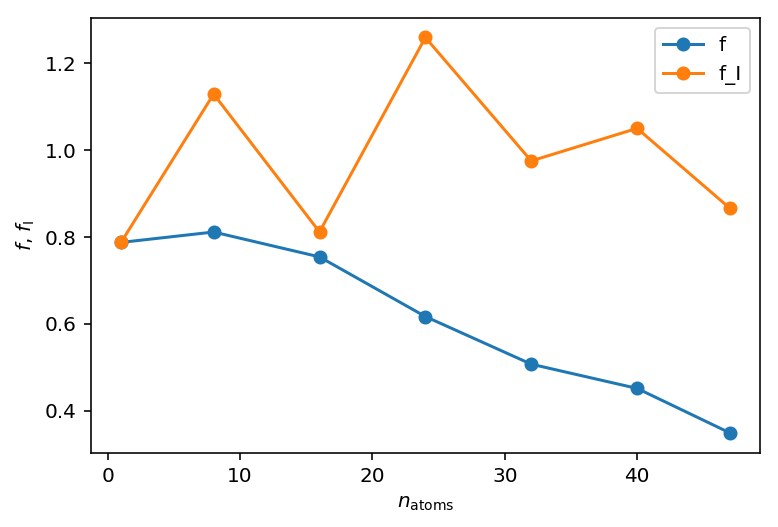

f_v = 0.3485 (exact result = 0.3333)


In [43]:
# plot the data
plt.plot( data.n, data.f,   'o-', label='f'  )
plt.plot( data.n, data.f_I, 'o-', label='f_I')
plt.legend()
plt.xlabel( r"$n_\mathrm{atoms}$" )
plt.ylabel( r"$f$, $f_\mathrm{I}$" )
plt.show()

# The tracer correlation factor in the single vacancy limit is 0.33333 [Friauf J. Appl. Phys. 33, 494 (1962)]
print( "f_v = {:.4f} (exact result = 0.3333)".format( data.f.values[-1] ) )

The collective correlation factor, $f_I$, should equal 1 at all particle concentrations, but has much worse statistics than the single particle (tracer) correlation factor. This is because the single particle correlation factor calculation includes an average over all particles in the simulation, whereas the collective correlation factor depends on a *sum* over all particles, and does not have this additional averaging. (cf. the comparison between simulated diffusion coefficients and ionic conductivities in <a href="#ref1">\[5\]</a>.)

## Interacting Particles

For non-interacting particles, all allowed particle jumps have equal probability. Introducing interactions changes the relative probabilities of each jump according to the corresponding change in total energy:

\begin{equation}
  P_i \propto 
  \begin{cases}
    \mathrm{exp}\left(\frac{\Delta E_i}{kT}\right),& \mathrm{if}\,\,\Delta E_i > 0 \\
    1,                                             & \mathrm{otherwise.}
  \end{cases}
\end{equation}

### Nearest-neighbour repulsion

The energy of any configuration of occupied sites, $j$ is given by
\begin{equation}
  E = \sum_j n_j^\mathrm{nn}E_\mathrm{nn},
\end{equation}
where $n^\mathrm{nn}_j$ is the number of occupied nearest neighbour sites for (occupied) site $j$.

#### Example - The Effect of Nearest-Neighbour repulsion on a Honeycomb Lattice

Nearest neighbour repulsion energies $E_\mathrm{nn}$ are set using 
```python
Simulation.set_nn_energy( <energy> ).  
```
In this example, the lattice is constructed using the optional argument
```python
alternating_sites=True
```
which divides the lattice into alternating sites labelled A and B.


In [44]:
def honeycomb_lattice_correlation_nn( n_atoms, nn_repulsion ):
    a, b = 4, 3
    spacing = 1.0
    n_jumps = 10000 # much longer simulations needed for reasonable statistics.
    n_equilibration_jumps = 100 # need to include equilibration jumps.
    s = lattice_mc.Simulation()
    # Setting alternating_sites=True assigns site labels 'A' and 'B' to alternating sites on the lattice.
    s.lattice = lattice_mc.init_lattice.honeycomb_lattice( a, b, spacing, alternating_sites=True )
    s.set_number_of_atoms( n_atoms )
    s.set_number_of_jumps( n_jumps )
    s.set_number_of_equilibration_jumps( n_equilibration_jumps )
    s.set_nn_energy( nn_repulsion * kT )
    s.setup_lookup_table() # Create a lookup table for jump probabilities to speed up the simulation
    s.run()
    # Order parameter to quantify the preference for either site A or site B.
    # Sites A and B are equivalent by symmetry, so we take the absolute difference in populations.
    order_parameter = fabs( s.average_site_occupations['A'] - s.average_site_occupations['B'] ) / 24
    return s.tracer_correlation, s.collective_correlation, order_parameter

In [45]:
def run_simulations( n_atoms, nn_energy, simulation_function, nproc, n_samples ):
    pool = multiprocessing.Pool( processes=nproc )
    f_data = []
    for n in n_atoms:
        for nn in nn_energy:
            calc_pool = ( ( n, nn ) for i in range( n_samples ) )
            f_sampled = np.array( pool.starmap( simulation_function, calc_pool ) )
            f = sum( f_sampled ) / n_samples
            f_data.append( [ n, nn, *f ] )
    return f_data

In [46]:
n_atoms = np.array( [ 1, 8, 16, 24, 32, 40, 47 ] )
nn_energy = [ 0.0, 1.0, 2.0, 3.0, 4.0 ]
results = run_simulations( n_atoms, nn_energy, honeycomb_lattice_correlation_nn, nproc=NPROCS, n_samples=NSAMPLES )
data = pd.DataFrame( np.row_stack( results ), columns = [ 'n_atoms', 'E_nn', 'f', 'f_I', 'order_parameter' ] )

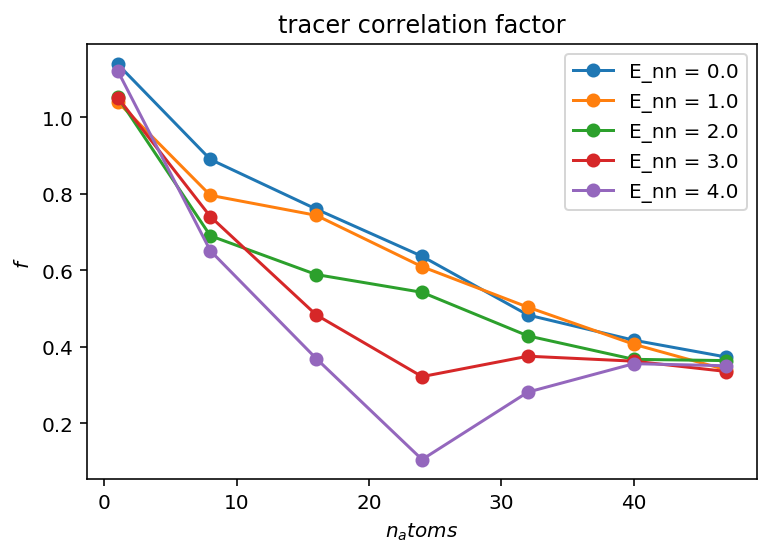

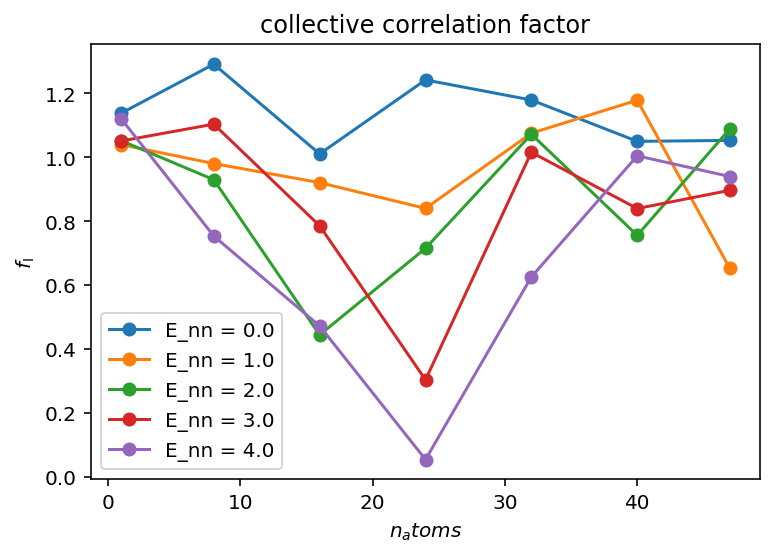

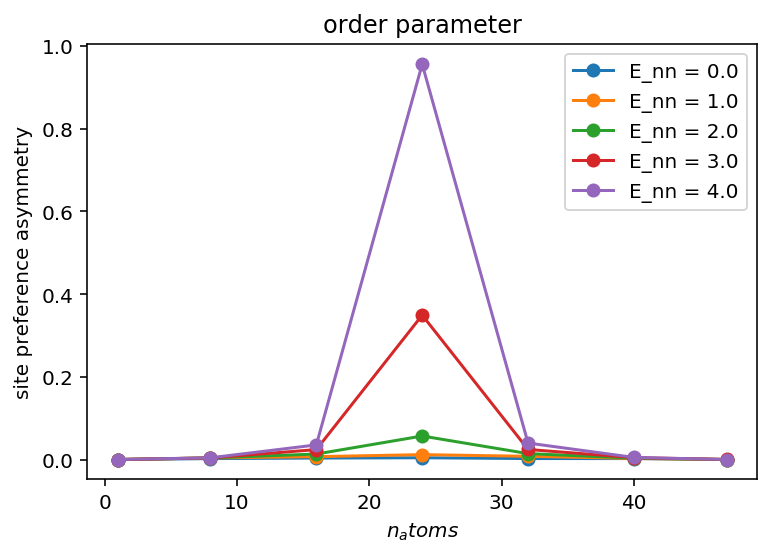

In [47]:
for nn in nn_energy:
    nn_data=data[data.E_nn==nn]
    plt.plot( nn_data.n_atoms, nn_data.f, 'o-', label="E_nn = {}".format(nn) )
    plt.legend()
    plt.xlabel( r"$n_atoms$" )
    plt.ylabel( r"$f$" )
    plt.title( 'tracer correlation factor' )
plt.show()

for nn in nn_energy:
    nn_data=data[data.E_nn==nn]
    plt.plot( nn_data.n_atoms, nn_data.f_I, 'o-', label="E_nn = {}".format(nn) )
    plt.legend()
    plt.xlabel( r"$n_atoms$" )
    plt.ylabel( r"$f_\mathrm{I}$" )
    plt.title( 'collective correlation factor' )
plt.show()

for nn in nn_energy:
    nn_data=data[data.E_nn==nn]
    plt.plot( nn_data.n_atoms, nn_data.order_parameter, 'o-', label="E_nn = {}".format(nn) )
    plt.legend()
    plt.xlabel( r"$n_atoms$" )
    plt.ylabel( r"site preference asymmetry" )
    plt.title( 'order parameter' )
plt.show()

As the nearest-neighbour repulsion energy increases, both $f$ and $f_I$ are decreased as the lattice occupancy approaches 50% (cf. results published in <a href="#ref1">\[6\]</a>). The order parameter plot shows that this is associated with a preference for all the mobile particles to order on one subset of alternating sites.

### On-site Energies

The on-site contribution to the energy is given by
\begin{equation}
  E = \sum_j E_\mathrm{site}^j.
\end{equation}
Within the code, sites are distinguished using labels, and different on-site energies can be set for each site label.

#### Example - The Effect of Site Inequivalence on a Honeycomb Lattice

Site occupation energied $E_\mathrm{site}$  are set using `Simulation.set_site_energies( <dict> )`.  
In this example, the lattice is constructed using the optional argument `alternating_sites=True`, which divides the lattice into alternating sites labelled A and B. The site energies are then set with
```python
s.set_site_energies( { 'A' : 0.0, 'B' : site_delta_E * kT } )
```

In [48]:
def honeycomb_lattice_correlation_si( n_atoms, site_delta_E ):
    a, b = 4, 3
    spacing = 1.0
    n_jumps = 10000 # much longer simulations needed for reasonable statistics.
    n_equilibration_jumps = 100 # need to include equilibration jumps
    s = lattice_mc.Simulation()
    s.lattice = lattice_mc.init_lattice.honeycomb_lattice( a, b, spacing, alternating_sites=True )
    s.set_number_of_atoms( n_atoms )
    s.set_number_of_jumps( n_jumps )
    s.set_number_of_equilibration_jumps( n_equilibration_jumps )
    s.set_site_energies( { 'A' : 0.0, 'B' : site_delta_E * kT } )
    s.setup_lookup_table() # Create a lookup table for jump probabilities to speed up the simulation
    s.run()
    a_site_preference = ( s.average_site_occupations['A'] - s.average_site_occupations['B'] ) / 24
    return s.tracer_correlation, s.collective_correlation, a_site_preference

In [59]:
def run_simulations( n_atoms, site_delta_E, simulation_function, nproc, n_samples ):
    pool = multiprocessing.Pool( processes=nproc )
    f_data = []
    for n in n_atoms:
        for dE in site_delta_E:
            calc_pool = ( ( n, dE ) for i in range( n_samples ) )
            f_sampled = np.array( pool.starmap( simulation_function, calc_pool ) )
            f = sum( f_sampled ) / n_samples
            f_data.append( [ n, dE, *f ] )
    return f_data

In [60]:
n_atoms = np.array( [ 1, 8, 16, 24, 32, 40, 47 ] )
site_delta_E = [ 0.0, 1.0, 2.0, 3.0, 4.0 ]
results = run_simulations( n_atoms, nn_energy, honeycomb_lattice_correlation_nn, nproc=NPROCS, n_samples=NSAMPLES )
data = pd.DataFrame( np.row_stack( results ), columns = [ 'n_atoms', 'delta_E_site', 'f', 'f_I', 'A site preference' ] )

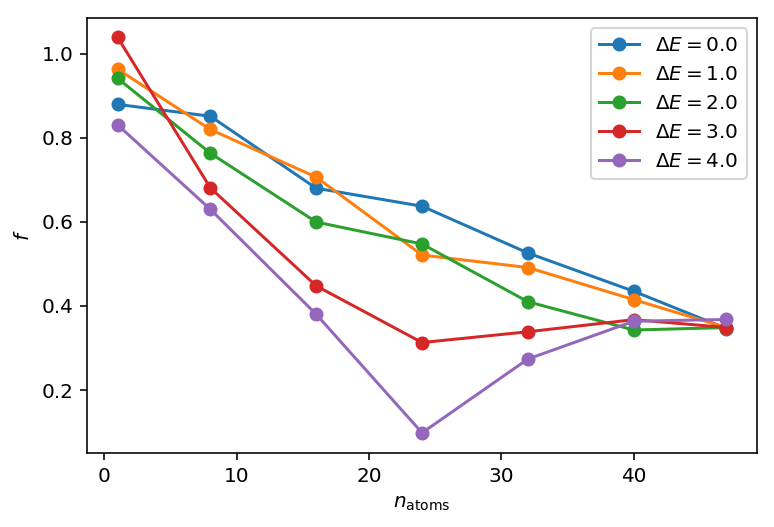

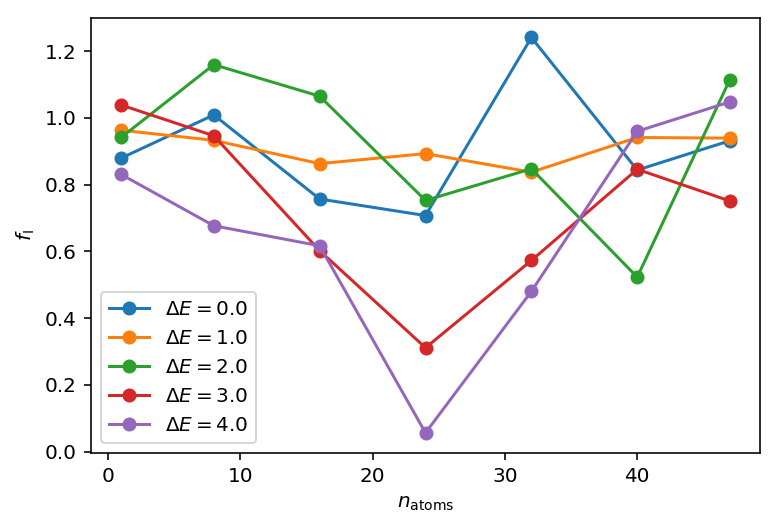

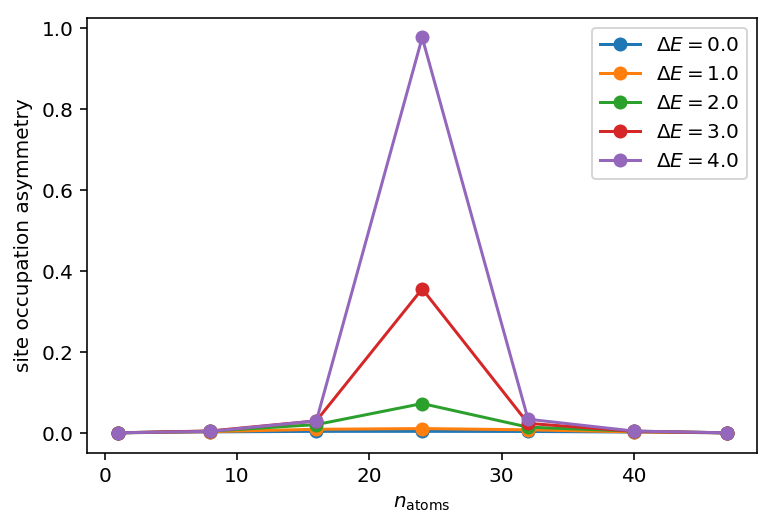

In [61]:
for dE in site_delta_E:
    nn_data=data[data.delta_E_site==dE]
    plt.plot( nn_data.n_atoms, nn_data.f, 'o-', label=r"$\Delta E={}$".format( dE ) )
    plt.legend()
    plt.xlabel( r"$n_\mathrm{atoms}$" )
    plt.ylabel( r"$f$" )
plt.show()

for dE in site_delta_E:
    nn_data=data[data.delta_E_site==dE]
    plt.plot( nn_data.n_atoms, nn_data.f_I, 'o-', label=r"$\Delta E={}$".format( dE ) )
    plt.legend()
    plt.xlabel( r"$n_\mathrm{atoms}$" )
    plt.ylabel( r"$f_\mathrm{I}$" )
plt.show()

for dE in site_delta_E:
    nn_data=data[data.delta_E_site==dE]
    plt.plot( nn_data.n_atoms, nn_data['A site preference'], 'o-', label=r"$\Delta E={}$".format( dE ) )
    plt.legend()
    plt.xlabel( r"$n_\mathrm{atoms}$" )
    plt.ylabel( r"site occupation asymmetry" )
plt.show()

Making the A and B sites inequivalent, by introducing on-site energies, has a similar effect to nearest-neighbour repulsion.

## Defining a Lattice from a Sites File

All the examples so far have used one of the built-in lattice generation routines. Arbitrary lattices can be constructed using 
```python
Simulation.define_lattice_from_file( <filename>, <cell lengths> )
```
A sites file starts with the number of sites, and then has the same number of blocks with the format:
```
site: <integer>
center: <float> <float> <float>
neighbours: <integer> × m
label: <string>
(optional) energy: <float>
```

So the top of a sites file might look like
```
576

site: 5
centre: 21.4669 -1.37099999975e-05 6.133405
neighbours: -2 -3 -4 -309
label: T

site: 10
centre: 21.4669 -1.37099999975e-05 30.667
neighbours: -6 -7 -8 -311
label: T
```

`site:` assigns an integer to each site that is used to identify it. Each site must have a unique identifying integer.  
`centre:` is the coordinate of the lattice site.  
`neighbours:` is the list of integers identifying the sites neighbouring this site.  
`label:` identifies this site as belonging to a group of sites.  
`energy:` sets the site energy (optional).

The `centre` and `neighbours` entries can be British or American English spellings (`centre`|`center`) and (`neighbours`|`neighbors`).

The program does not check that your cell paramateres are consistent with the coordinates provided in the site file. Instead, when the lattice is constructed, periodic boundary conditions are applied, and site coordinates lying outside the (orthorhombic) cell are mapped to an equivalent position inside the cell.

### Example: Lattice-Gas Monte Carlo Simulation on a Garnet Lattice

This reads the lattice site data from `llzo_lattice_site_list.dat`, which contains the site coordinates and connectivity for a 2&times;2&times;2 supercell of Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub> [\[1\]](#ref1).

In [52]:
def garnet_lattice_correlation( n_atoms ):
    n_jumps = 10000
    n_equilibration_jumps = 100
    s = lattice_mc.Simulation()
    s.define_lattice_from_file( 'llzo_lattice_site_list.dat', [ 49.0672361, 49.0672361, 49.0672361 ] )
    s.set_number_of_atoms( n_atoms )
    s.set_number_of_jumps( n_jumps )
    s.set_number_of_equilibration_jumps( n_equilibration_jumps )
    s.setup_lookup_table() # Create a lookup table for jump probabilities to speed up the simulation
    s.run()
    return s.tracer_correlation, s.collective_correlation

In [53]:
def run_simulations( n_atoms, simulation_function, nproc, n_samples ):
    pool = multiprocessing.Pool( processes=nproc )
    f_data = []
    for n in n_atoms:
        calc_pool = ( n for i in range( n_samples ) )
        f_sampled = np.array( pool.map( simulation_function, calc_pool ) )
        f = sum( f_sampled ) / n_samples
        f_data.append( [ n, *f ] )
    return f_data

In [54]:
n_atoms = np.array( [ 1, 96, 192, 288, 384, 480, 575 ] )
results = run_simulations( n_atoms, garnet_lattice_correlation, nproc=NPROCS, n_samples=NSAMPLES )
data = pd.DataFrame( np.row_stack( results ), columns=[ 'n', 'f', 'f_I' ] )

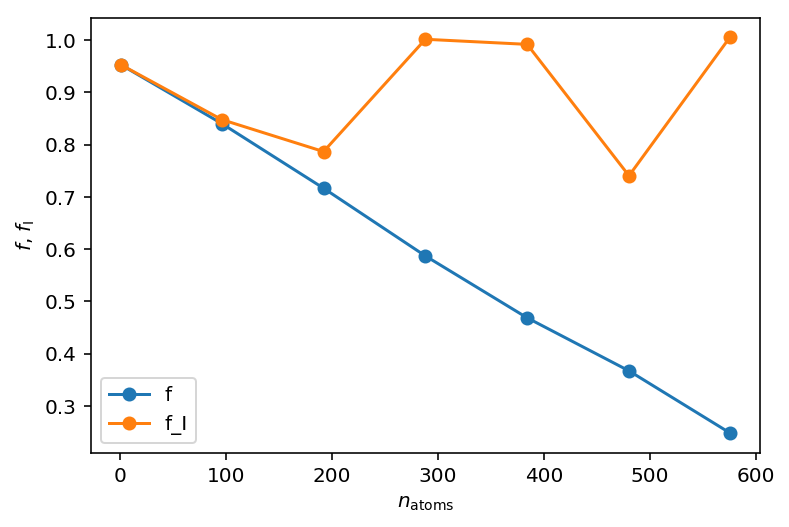

In [55]:
# plot the data
plt.plot( data.n, data.f,   'o-', label='f'  )
plt.plot( data.n, data.f_I, 'o-', label='f_I')
plt.legend()
plt.xlabel( r"$n_\mathrm{atoms}$" )
plt.ylabel( r"$f$, $f_\mathrm{I}$" )
plt.show()

## Running simulations for a set time, instead of a set number of jumps

Call the Simulation `.run()` method with the optional argument `for_time=<simulation time in seconds>`.  

e.g.

```python
s = lattice_mc.Simulation()
```
&hellip;
```
s.run( for_time=1.0 ) # run for 1 second.
```

# References

<span id='ref1' />[1] B. J. Morgan, In Preparation.</span>  
<span id='ref2' />[2] A. Van der Ven *et al.* [*Acc. Chem. Res.* **46**, 1216 (2013)](https://dx.doi.org/10.1021/ar200329r).    
<span id='ref3' />[3] G. E. Murch [*Sol. Stat. Ionics* **7**, 177 (1982)](https://dx.doi.org/10.1016/0167-2738%2882%2990050-9).   
<span id='ref4' />[4] R. Kutner [*Phys. Lett.* **81A**, 239 (1981)](https://dx.doi.org/10.1016/0375-9601%2881%2990251-6).  
<span id='ref5' />[5] Morgan and Madden, [*J. Phys. Condens. Matter* **24**, 275303 (2012)](http://www.iopscience.iop.org/article/10.1088/0953-8984/24/27/275303/).  
<span id='ref6' /> [6] G. E. Murch & R. J. Thorn, [Phil. Mag. **36** 529 (1977)](http://dx.doi.org/10.1080/14786437708239737).